In [28]:
import pandas as pd
from scipy.stats import ttest_ind

In [30]:
# Load dataset
df = pd.read_csv('flashmist_data.csv')

# Display the first 5 rows
df.head()

,user_id,ab_group,converted,retention_days,retained,clickstream_path,review_text,sentiment,pipeline_status
0,6c94bddb-6845-402c-8dbb-300adf7e1ab7,A,0,14,1,Dashboard > Settings > Dashboard > Logout > Da...,Too slow.,negative,Success
1,ba2f7e58-7429-4e7e-a1de-42e86c3ece75,B,1,7,1,Logout > TaskCreate > TaskCreate > Logout > Lo...,Very intuitive,positive,Success
2,852a7786-5698-496a-9408-5aa33edbc6a2,B,0,9,1,FileUpload > Homepage > FileUpload > FileUploa...,Needs improvement,negative,Success
3,a673553b-58da-47d6-98f9-b612a0990737,B,0,5,0,TaskCreate > TaskCreate > FileUpload > Dashboa...,App crashes often.,negative,Success
4,a8ea1a99-75b2-4a6e-8a13-2d5859101102,A,0,9,1,Homepage > Settings > Dashboard > Homepage > F...,Too slow.,negative,Success


### A/B Testing for Product Feature

In [33]:
# Data Exploration 
# -- Understand base conversion rate per group and check if group sizes were similar for clean A/B test--
df[['ab_group', 'converted']].groupby('ab_group').agg(['mean', 'count'])

converted       
              mean  count
ab_group                 
A         0.179100  25053
B         0.220988  24947

In [35]:
# Data Cleaning
# -- Ensure only valid A or B groups exist and removed missing/null converted values--
df = df[df['ab_group'].isin(['A', 'B'])]
df = df.dropna(subset=['converted'])

# -- Ensure 'converted' column is numeric --
df['converted'] = pd.to_numeric(df['converted'], errors='coerce')

# --Drop any NaNs (important to prevent errors in t-test)--
df_clean = df.dropna(subset=['ab_group', 'converted'])

In [37]:
# Q1: Which version leads to better conversion?
conversion_rates = df.groupby('ab_group')['converted'].mean()
print (conversion_rates)

ab_group
A    0.179100
B    0.220988
Name: converted, dtype: float64


In [39]:
# Q2: Are the observed differences statistically significant?
# --Extract the groups--
group_a = df_clean[df_clean['ab_group'] == 'A']['converted']
group_b = df_clean[df_clean['ab_group'] == 'B']['converted']

# --Run the t-test--
t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False)  # Welch’s t-test

# --Print results--
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result is statistically significant: conversion rates differ.")
else:
    print("No significant difference in conversion rates between A and B.")

T-statistic: -11.7220
P-value: 0.0000
Result is statistically significant: conversion rates differ.


In [41]:
# Q3: What user segments respond best?
df.groupby(['ab_group', 'retained'])['converted'].mean().unstack()

retained,0,1
ab_group,,
A,0.172435,0.180089
B,0.222570,0.220756


### User Retention Analysis

In [46]:
# Data Exploration 
df['retention_days'].describe()
df['retained'].value_counts(normalize=True)

retained
1    0.8713
0    0.1287
Name: proportion, dtype: float64

In [48]:
# Data Cleaning
df = df[df['retention_days'] <= 30]

<Axes: ylabel='Frequency'>

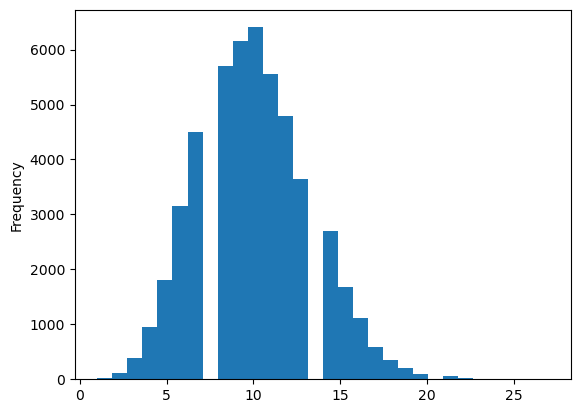

In [50]:
# Q1: Key drop-off points?
df['retention_days'].plot.hist(bins=30)

In [56]:
# Q2: Product usage vs. retention
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
click_matrix = vectorizer.fit_transform(df['clickstream_path'])

print (click_matrix)

# Compare average frequency of each page between retained vs. non-retained

  (0, 0)	5
  (0, 4)	2
  (0, 3)	2
  (0, 5)	1
  (1, 0)	2
  (1, 3)	3
  (1, 5)	3
  (1, 1)	1
  (1, 2)	1
  (2, 1)	5
  (2, 2)	2
  (3, 0)	1
  (3, 4)	3
  (3, 5)	4
  (3, 1)	2
  (4, 0)	2
  (4, 4)	1
  (4, 1)	2
  (4, 2)	3
  (5, 0)	2
  (5, 3)	1
  (5, 5)	1
  (5, 1)	2
  (5, 2)	2
  (6, 0)	2
  :	:
  (49993, 1)	1
  (49993, 2)	2
  (49994, 0)	2
  (49994, 3)	3
  (49994, 2)	2
  (49995, 0)	1
  (49995, 4)	1
  (49995, 3)	2
  (49995, 5)	3
  (49995, 1)	3
  (49996, 3)	1
  (49996, 5)	2
  (49996, 1)	3
  (49997, 0)	1
  (49997, 4)	1
  (49997, 3)	2
  (49997, 5)	1
  (49997, 1)	1
  (49998, 0)	2
  (49998, 4)	3
  (49998, 5)	2
  (49998, 1)	2
  (49998, 2)	1
  (49999, 0)	2
  (49999, 1)	1


### Sentiment Analysis on Product Reviews

In [65]:
# Data Exploration
df['sentiment'].value_counts()
df['review_text'].sample(5)

1044       Amazing support
30210    Needs improvement
530        Amazing support
6923     Needs improvement
40210      Amazing support
Name: review_text, dtype: object

In [67]:
# Data Cleaning
df = df[df['review_text'].notnull()]

In [69]:
# Q1: Prevailing sentiments?
df['sentiment'].value_counts(normalize=True)

sentiment
positive    0.50084
negative    0.49916
Name: proportion, dtype: float64

### Clickstream Analysis

In [78]:
# Data Exploration
df['clickstream_path'].sample(5)

29213                    TaskCreate > Homepage > Dashboard
10588                   FileUpload > TaskCreate > Homepage
47272            Homepage > Logout > Dashboard > Dashboard
29701    Settings > Settings > Logout > Dashboard > Tas...
6070     Dashboard > Settings > Homepage > TaskCreate >...
Name: clickstream_path, dtype: object

In [80]:
# Data Cleaning
df['clickstream_list'] = df['clickstream_path'].str.split(' > ')

In [82]:
# Q1: Navigation through key workflows
# Extract path frequency or key transitions
from collections import Counter
transitions = []

for path in df['clickstream_list']:
    transitions += zip(path, path[1:])

Counter(transitions).most_common(10)

[(('FileUpload', 'Dashboard'), 7776),
 (('FileUpload', 'Homepage'), 7756),
 (('Dashboard', 'FileUpload'), 7752),
 (('Dashboard', 'Settings'), 7751),
 (('Settings', 'Logout'), 7747),
 (('TaskCreate', 'Logout'), 7737),
 (('Homepage', 'Settings'), 7725),
 (('Logout', 'Logout'), 7710),
 (('Logout', 'FileUpload'), 7696),
 (('TaskCreate', 'Homepage'), 7691)]

In [84]:
# Q2: Bottlenecks or loops
df['has_loop'] = df['clickstream_list'].apply(lambda x: len(set(x)) < len(x))

In [86]:
# Q3: Clickstream vs. churn
# Churn if not retained
df['churned'] = 1 - df['retained']

# Analyze avg. steps or last page before churn

In [88]:
df.to_csv('cleaned_flashmist.csv', index=False)